In [30]:
!python3 --version

Python 3.10.13


In [31]:
%%capture --no-stderr
%pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core python-dotenv

In [32]:
%load_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [33]:
import os
from dotenv import load_dotenv
load_dotenv()

# # load API keys; you will need to obtain these if you haven't yet
os.environ["OPENAI_API_KEY"] = os.environ.get("OPENAI_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.environ.get("LANGCHAIN_API_KEY")
os.environ["TAVILY_API_KEY"] = os.environ.get("TAVILY_API_KEY")

# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

# Create Agents
The following helper functions will help create agents. These agents will then be nodes in the graph.

In [34]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import START, StateGraph, END


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

# Define tools
We will also define some tools that our agents will use in the future

In [35]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

# Create graph
Now that we've defined our tools and made some helper functions, will create the individual agents below and tell them how to talk to each other using LangGraph.

## Define State
We first define the state of the graph. This will just a list of messages, along with a key to track the most recent sender

In [37]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_openai import ChatOpenAI


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

## Define Agent Nodes
We now need to define the nodes. First, let's define the nodes for the agents.

In [39]:
import functools

from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = ChatOpenAI(model="gpt-4-1106-preview")

# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# chart_generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

## Define Tool Node
We now define a node to run the tools

In [40]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

## Define Edge Logic
We can define some of the edge logic that is needed to decide what to do based on results of the agents

In [42]:
# Either agent can decide to end
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

## Define the Graph
We can now put it all together and define the graph!

In [43]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.add_edge(START, "Researcher")
graph = workflow.compile()

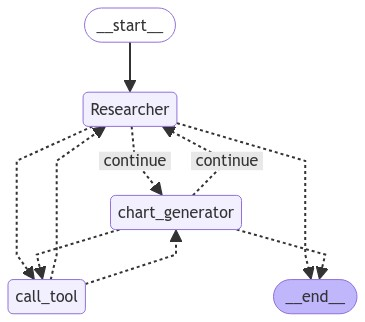

In [44]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Invoke
With the graph created, you can invoke it! Let's have it chart some stats for us.

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_EDgMOpyDM5h3CyeVUzHhKFLZ', 'function': {'arguments': '{"query": "India GDP 2020"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_pHm92XwLrQNRwmdE5rzr1ppt', 'function': {'arguments': '{"query": "India GDP 2021"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_7VhTxKcapGOzFm0sPKg7U4Zx', 'function': {'arguments': '{"query": "India GDP 2022"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_QqoKQFsXlcC03UiQJh3ibOd6', 'function': {'arguments': '{"query": "India GDP 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_qk3xXfBcI99hsE4diHJfwQqi', 'function': {'arguments': '{"query": "India GDP 2024"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 201, 'prompt_tokens': 229, 'total_tokens': 430}, 'model

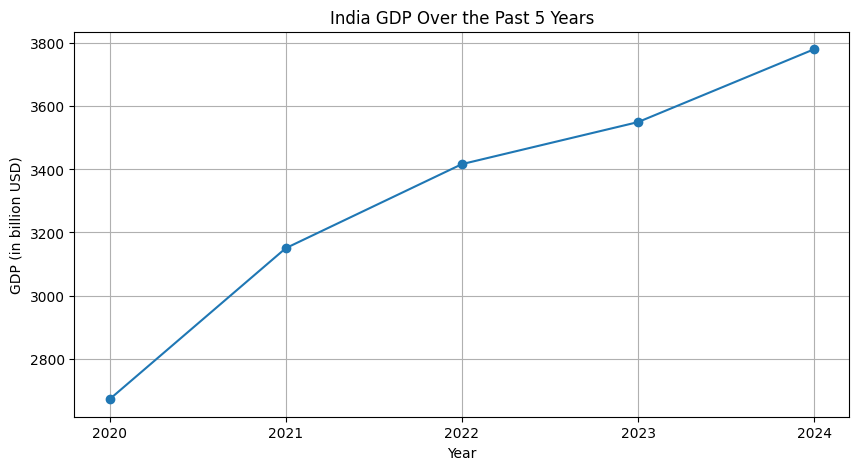

{'chart_generator': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_EDgMOpyDM5h3CyeVUzHhKFLZ', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# Data for India\'s GDP (in billion USD) for the last 5 years\\nyears = [\'2020\', \'2021\', \'2022\', \'2023\', \'2024\']\\ngdp_values = [2671.60, 3150.31, 3416.65, 3549.92, 3780.86]  # Estimated value for 2024\\n\\n# Creating the line graph\\nplt.figure(figsize=(10, 5))\\nplt.plot(years, gdp_values, marker=\'o\')\\n\\n# Adding titles and labels\\nplt.title(\'India GDP Over the Past 5 Years\')\\nplt.xlabel(\'Year\')\\nplt.ylabel(\'GDP (in billion USD)\')\\nplt.grid(True)\\n\\n# Show the plot\\nplt.show()"}', 'name': 'python_repl'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 193, 'prompt_tokens': 6847, 'total_tokens': 7040}, 'model_name': 'gpt-4-1106-preview', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None

In [45]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the India's GDP over the past 5 years with the current year being 2024,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_yyPDGHxBi7IqdsV6ci0fKda7', 'function': {'arguments': '{"query": "India GDP 2020"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_jbImJmdcEkioqRuPAcUuapWj', 'function': {'arguments': '{"query": "India GDP 2021"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_iCszvYLnOuELOYnakD7HO4Wx', 'function': {'arguments': '{"query": "India GDP 2022"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_r1FLiJL0dATagms4WGc6naBu', 'function': {'arguments': '{"query": "India GDP 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_ZFUgp7zFTxpNaOyJZRdNYedk', 'function': {'arguments': '{"query": "India GDP 2024"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 201, 'prompt_tokens': 233, 'total_tokens': 434}, 'model

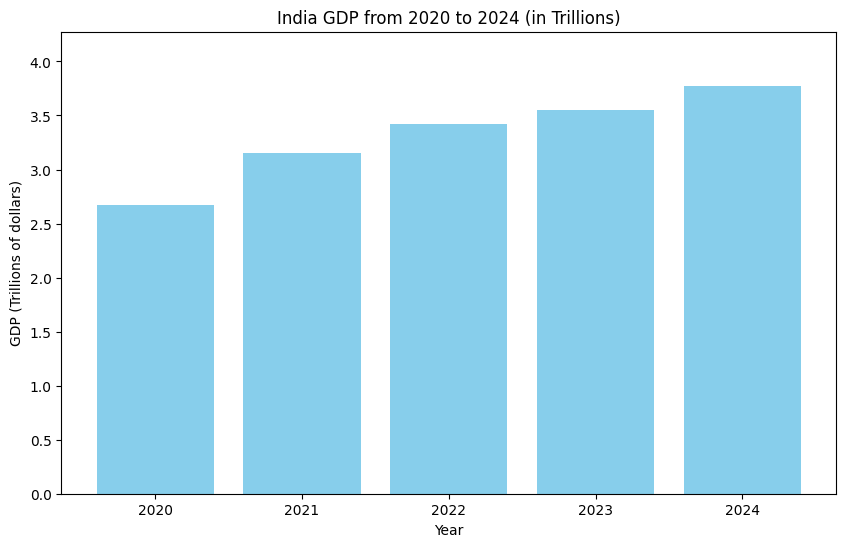

{'chart_generator': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_q82t5WpiqurRJEcQXGg36SMu', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# India\'s GDP data from 2020 to 2024 in trillions of dollars\\nyears = [\'2020\', \'2021\', \'2022\', \'2023\', \'2024\']\\ngdp_values = [2.671, 3.150, 3.417, 3.550, 3.775]\\n\\n# Creating the bar chart\\nplt.figure(figsize=(10, 6))\\nplt.bar(years, gdp_values, color=\'skyblue\')\\nplt.title(\'India GDP from 2020 to 2024 (in Trillions)\')\\nplt.xlabel(\'Year\')\\nplt.ylabel(\'GDP (Trillions of dollars)\')\\nplt.xticks(years)\\nplt.ylim(0, max(gdp_values) + 0.5)\\n\\n# Display the bar chart\\nplt.show()"}', 'name': 'python_repl'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 202, 'prompt_tokens': 7595, 'total_tokens': 7797}, 'model_name': 'gpt-4-1106-preview', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None},

In [46]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the India's total GDP over the past 5 years in trillions with the current year being 2024,"
                " then draw a bar chart of it."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_vxdHe1GlkDD3snL82ITQa8x8', 'function': {'arguments': '{"query": "India GDP 2020"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_XYfWIE5QYMIoTuUL1sBOEMGj', 'function': {'arguments': '{"query": "India GDP 2021"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_Arnv5MSLSguM4XD8x9HfykYN', 'function': {'arguments': '{"query": "India GDP 2022"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_kaDRHzsEY2OfpUGmOlFM7KgI', 'function': {'arguments': '{"query": "India GDP 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_4nrrSOjxxz4T2FAhYZuMy9Kh', 'function': {'arguments': '{"query": "India GDP 2024"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 201, 'prompt_tokens': 256, 'total_tokens': 457}, 'model

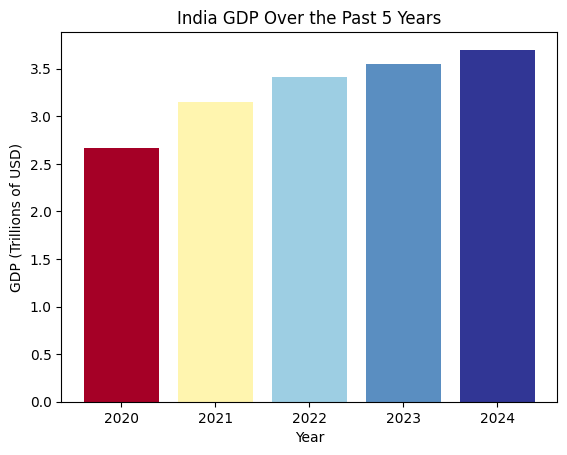

{'chart_generator': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_a52WPqcpFVIZZwImeq6OClyv', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\nimport numpy as np\\n\\n# GDP values in trillions of US dollars\\nyears = [\'2020\', \'2021\', \'2022\', \'2023\', \'2024\']\\ngdp_values = [2.6716, 3.15031, 3.41665, 3.54992, None] # Placeholder None for 2024\\n\\n# Placeholder for 2024 GDP in trillion, this will be replaced once we have the actual value\\ngdp_values[-1] = 3.7 # Assuming a hypothetical value for demonstration\\n\\n# Finding min and max for color gradient\\nmin_gdp = min(gdp_values)\\nmax_gdp = max(gdp_values)\\n\\n# Normalizing GDP values to find the right color\\nnorm = plt.Normalize(min_gdp, max_gdp)\\ncolors = plt.cm.RdYlBu(norm(gdp_values))\\n\\n# Creating the bar chart\\nfig, ax = plt.subplots()\\nbar_chart = ax.bar(years, gdp_values, color=colors)\\n\\n# Adding labels and title\\nax.set_xlabel(\'Year\')\\nax.set_yla

In [29]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the India's total GDP over the past 5 years in trillions with the current year being 2024,"
                " then draw a bar chart of it, bar color: with the lowest value in red and highest value in red and intermediates with gradient of both colors."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 500},
)
for s in events:
    print(s)
    print("----")